# Dynamic Pricing Model Using Thompson Sampling

This notebook demonstrates dynamic price optimization for discrete price levels using Thompson sampling [1].

### Use Case
We assume an environment with a single SKU and discrete price levels. We also assume fixed inventory constraint. Initially, we do not have any sales data and do not know how market responses on each of these price levels. Our goal is build an agent that efficiently tests various price levels and converges to the optimal value.

### Prototype: Approach and Data
We start with non-informative prior distribution for each price level and use Thompson sampling to iteratively update the posterior distributions. At each time step, the revenue-optimal price is selected. We use a basic demand simulator, no external datasets are used. 

### Usage and Productization
This prototype can be used to implement dynamic pricing services. It provides enough flexibility for implementing custom revenue (objective) functions with various constraints on price levels and inventory.

### References
1. Ferreira K., Simchi-Levi D., and Wang H. -- Online Network Revenue Management Using Thompson Sampling, November 2017

In [21]:
import numpy as np
from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats 
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))
    
plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})
plt.rcParams.update({'pdf.fonttype': 'truetype', 'font.size': 18})

# Step 1: Determine Optimal Prices Using Numerical Optimization

In [5]:
# Find the optimal distribution of prices (price probabilities) given fixed price levels, 
# corresponding demand levels, and available product inventory.
# 
# Inputs:
#   prices, demands, and revenues are vectors (i-th element corresponds to i-th price level)
#   inventory is a scalar (number of available units)
def optimal_price_probabilities(prices, demands, inventory):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [6]:
# Optimization procedure test
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]
demands = list(map(lambda p: 50 - 7*p, prices))
revenues = np.multiply(prices, demands)
print(demands)
print(revenues)
print(optimal_price_probabilities(prices, demands, 60))

[36.07, 32.57, 29.07, 25.57, 22.07, 18.57]
[71.78 81.1  86.92 89.24 88.06 83.38]
[8.31e-13 1.66e-12 4.68e-12 1.00e+00 1.16e-11 2.14e-12]


# Step 2: Optimize Prices Dynamically Using Thompson Sampling 

In [ ]:
prices = [1.99, 2.49, 2.99, 3.49, 3.99, 4.49]

# Hidden (true) demand parameters - a linear demand function is assumed
demand_a = 50
demand_b = 7

# prior distribution for each price - gamma(α, β)
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 30.00, 'beta': 1.00, 'mean': 30.00})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = demand_a - demand_b * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))
        
T = 50
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 60)
    
    # select one best price
    price_index_t = np.random.choice(len(prices), 1, p=price_probs)[0]
    price_t = prices[price_index_t]
    
    # sell at the selected price and observe demand
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # update model parameters
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

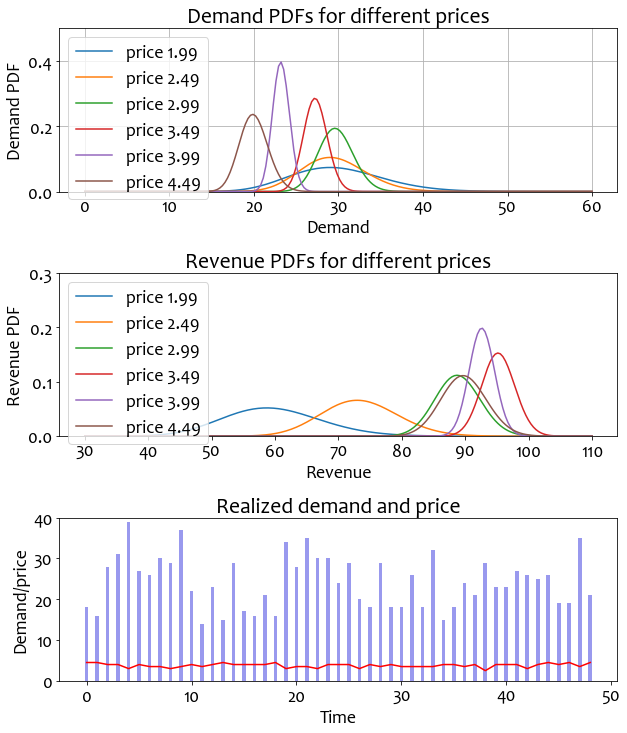

In [26]:
def visualize_snapshot(t):
    plt.subplot(3, 1, 1)
    plt.xlabel('Demand')
    plt.ylabel('Demand PDF')
    plt.title('Demand PDFs for different prices')
    x = np.linspace(0, 60, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.5])
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.xlabel('Revenue')
    plt.ylabel('Revenue PDF')
    plt.title('Revenue PDFs for different prices')
    x = np.linspace(30, 110, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha']*params['price'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.3])
    
    plt.subplot(3, 1, 3)
    plt.xlabel('Time')
    plt.ylabel('Demand/price')
    plt.title('Realized demand and price')
    prices = [h[0] for h in history]
    demands = [h[1] for h in history]
    plt.plot(range(0, t+1), np.array(prices)[0:t+1], 'r-') 
    plt.bar(range(0, T-1), np.pad(np.array(demands)[0:t+1], (0, T-2-t), 'constant'), 0.35, color='#9999ee')
    plt.ylim([0, 40])

fig = plt.figure(figsize = (10, 12))
plt.subplots_adjust(hspace = 0.5)
visualize_snapshot(T - 2)                 # visualize the final state of the simulation
plt.show()

In [23]:
# Render and save the animation of the simulation process

fig = plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)

t = 0
def animate(f):
    global t
    fig.clear()
    visualize_snapshot(t)
    t = t + 1
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=2800)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-3, repeat = True)

ani.save('thompson_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)